# Bright SNe lightcurves
### Roy Williams
Grab some bright supernovae and plot them.  Demo of:
* /query/
* /lightcurves/

### Python (3 only) requirements - pip install
lasair, matplotlib


In [ ]:
!pip install lasair

  Created wheel for lasair: filename=lasair-0.0.1-cp37-none-any.whl size=5400 sha256=8400a2da515296904e540d3a36a5ca4e3d34deb29058262dba503860b8c48b22
  Stored in directory: /root/.cache/pip/wheels/90/14/ca/ebc366bda99df15e2f2a285ad518e6f54e586f9e493a761c8a
Successfully built lasair


In [ ]:
import sys, time
import matplotlib.pyplot as plt
import numpy as np

### Grab my Lasair API token
Get your token before you start.  If you haven't got a Lasair account you can register here: https://lasair-ztf.lsst.ac.uk/signup.  Use the curl command below to get your token & set the last line of the next cell to be your token ID.

```bash
curl --data "username=myusername&password=***********" https://lasair-ztf.lsst.ac.uk/api/auth-token/
```
You should get the following response:
```json
{"token":"4b762569bb349bd8d60f1bc7da3f39dbfaefff9a"}
```
We can use this token temporarily, but note that this test token will only allow a very small number of requests per hour!  Hence it may be disabled when you come to test this code.

In [ ]:
from lasair import LasairError, lasair_client as lasair

try:
    import settings
    token = settings.token
except:
    token = '4b762569bb349bd8d60f1bc7da3f39dbfaefff9a'
L = lasair(token, endpoint = "https://lasair-ztf.lsst.ac.uk/api")

### Query for objects with the Sherlock classification SN

In [ ]:
# Get the objects that are CURRENTLY brighter than mag 19 in both g and r, AND
# have more than 12 positive flux detections, AND sherlock thinks the object is
# a supernova. Must be a ZTF21 object.
conditions = """
sherlock_classifications.classification = "SN"
AND objects.gmag < 19 AND objects.rmag < 19
AND objects.ncandgp > 12
AND objects.objectId like 'ZTF23%'
"""

In [ ]:
# Just join the objects table and the sherlock_classifications table, just
# pulling out the objectId.
rows = L.query(
    'objects.objectId',
    'objects, sherlock_classifications',
    conditions,
    limit=10)
objectIds = [row['objectId'] for row in rows]

### Plot lightcurve function

In [ ]:
def plotLC(lightcurve):
    objectId = lightcurve['objectId']
    jd_now = time.time()/86400 + 40587.0 + 2400000.5
    color = {1:'green', 2:'red'}
    for fid in [1,2]:
        since = []
        magpsf = []
        sigmapsf = []
        for cand in lightcurve['candidates']:
            if cand['fid'] == fid:
                since.append(cand['jd'] - jd_now)
                magpsf.append(cand['magpsf'])
                sigmapsf.append(cand['sigmapsf'])
        plt.errorbar(since, magpsf, yerr=sigmapsf, c=color[fid])
        plt.xlabel("days before %.2f" % jd_now)
        plt.ylabel("psf mag")
        plt.title('https://lasair-ztf.lsst.ac.uk/objects/%s' % objectId)
    plt.gca().invert_yaxis()
    plt.show()

### Grab and plot the lightcurves

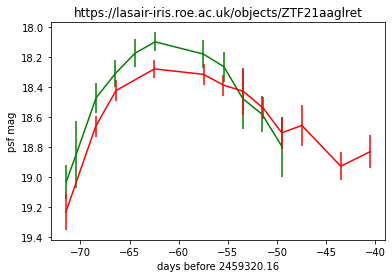

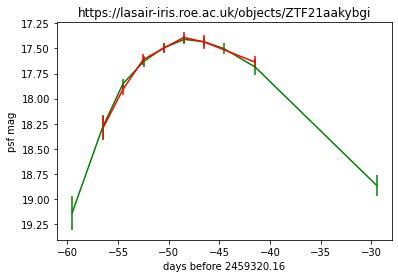

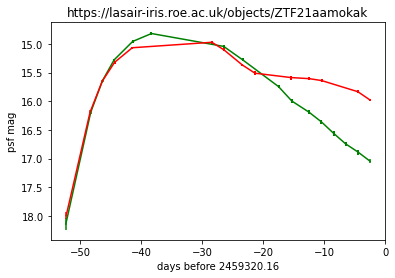

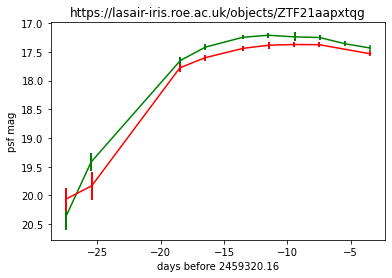

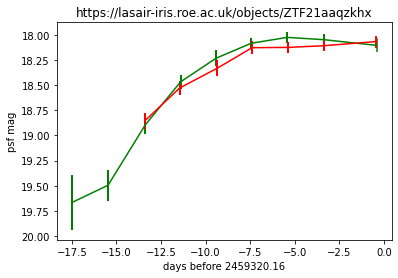

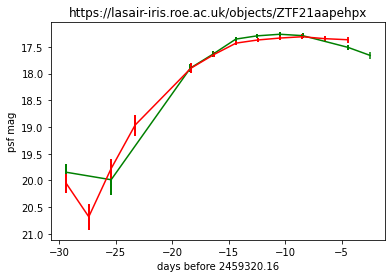

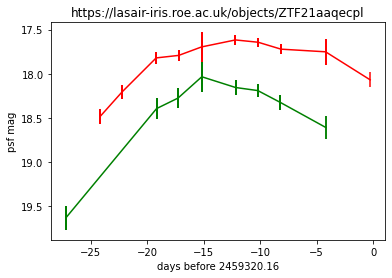

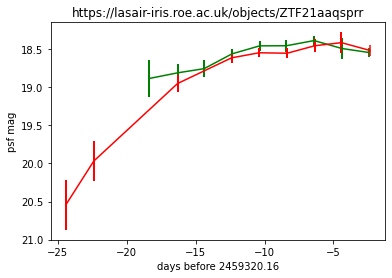

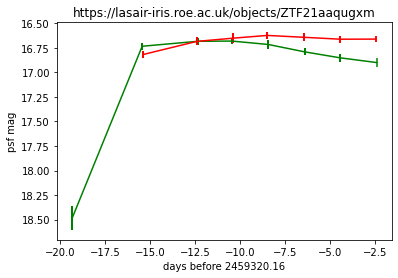

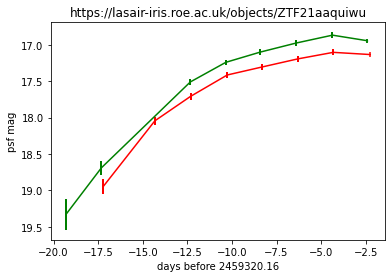

In [ ]:
lcs = L.lightcurves(objectIds)

# Yes - I can get the object and lightcurves at the same time using objects function, but let's use the lightcurves function instead.
# In this case I have to split the candidates and non-candidates manually.
for obj, lc in zip(objectIds, lcs):
    detectionsOnly = []
    for l in lc['candidates']:
        if 'candid' in l.keys():
            detectionsOnly.append(l)

    plotLC({'objectId': obj, 'candidates': detectionsOnly})